<a href="https://colab.research.google.com/github/s-mishra/statrethinking_lectures_numpyro/blob/main/week2/iwona_rethinking_week_2_chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Useful links:

* [HOMEWORK](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework)

* [Book code translated into NumPyro](https://fehiepsi.github.io/rethinking-numpyro/)

* [Book and homework code in Python/PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2)

* [NumPyro documentation](http://num.pyro.ai/en/stable/api.html)

* [NumPyro examples](http://num.pyro.ai/en/latest/index.html#introductory-tutorials)

* [Other languagaes and videos](https://github.com/rmcelreath/stat_rethinking_2020)

In [1]:
!pip install numpyro


     |████████████████████████████████| 250 kB 5.0 MB/s 


In [2]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

# Homework week 2

 https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week02

## Exercise 1


The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

---

In other words, find the expected (mean) and 89% percentile interval for heights of people with weights:
45, 40, 65, 31



In [3]:
# load the dataset with the Kung census from github
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', delimiter=';')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


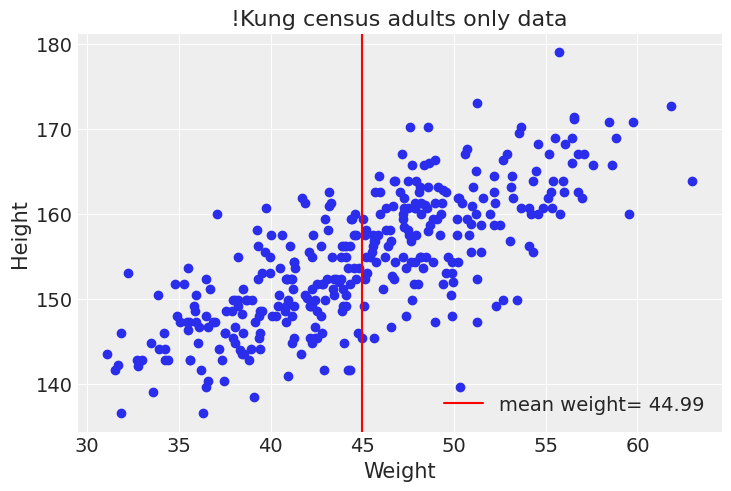

In [4]:
# get only adults data for now
df_adults = df[df['age'] >= 18]
avg_weight = df_adults.weight.mean()


plt.scatter(df_adults.weight, df_adults.height)
plt.axvline(x=avg_weight, label='mean weight= ' + str(round(avg_weight,2)), c='red')

plt.ylabel('Height')
plt.xlabel('Weight')
plt.title('!Kung census adults only data')
plt.legend()
plt.show()


In [5]:
# fit a linear model

def model(weight=None, height=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(165, 20))  # I just put my height in the prior
    beta = numpyro.sample("beta", dist.LogNormal(0, 1))  # same as in the book
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50)) # same as in the book
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta * (weight - avg_weight))
    # likelihood
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)   # not sure if i follow what this is doing


guide = numpyro.infer.autoguide.AutoLaplaceApproximation(model)
# Evidence Lower Bound
svi = numpyro.infer.SVI(
    model, guide, numpyro.optim.Adam(1), numpyro.infer.Trace_ELBO(), 
    weight=df_adults.weight.values, height=df_adults.height.values
)
svi_result = svi.run(random.PRNGKey(0), 2000,  progress_bar = True)
# svi.run returns a namedtuple with fields params and losses where params holds the optimized values at numpyro.param sites, and losses is the collected loss during the process.

100%|██████████| 2000/2000 [00:01<00:00, 1673.47it/s, init loss: 40625.9766, avg. loss [1901-2000]: 1078.3810]


In [6]:
svi_result

SVIRunResult(params={'auto_loc': DeviceArray([ 1.5459900e+02, -9.9573947e-02, -2.1799512e+00], dtype=float32)}, state=SVIState(optim_state=(DeviceArray(2000, dtype=int32), OptimizerState(packed_state=([DeviceArray([ 1.5459900e+02, -9.9573947e-02, -2.1799512e+00], dtype=float32), DeviceArray([ 2.5327290e-05,  1.5646222e-06, -5.8226291e-05], dtype=float32), DeviceArray([4.7297657e+01, 1.9246522e+03, 5.3823969e+05], dtype=float32)],), tree_def=PyTreeDef({'auto_loc': *}), subtree_defs=(PyTreeDef((*, *, *)),))), mutable_state=None, rng_key=DeviceArray([2238448716, 3297768858], dtype=uint32)), losses=DeviceArray([40625.977 , 10838.428 ,  5912.6304, ...,  1078.3807,
              1078.3806,  1078.3806], dtype=float32))

In [7]:
svi_result.params  # so these are values of alpha, beta, sigma???

{'auto_loc': DeviceArray([ 1.5459900e+02, -9.9573947e-02, -2.1799512e+00], dtype=float32)}

In [8]:
svi_result.losses

DeviceArray([40625.977 , 10838.428 ,  5912.6304, ...,  1078.3807,
              1078.3806,  1078.3806], dtype=float32)

In [9]:
# sample from the posterior
samples = guide.sample_posterior(random.PRNGKey(1), svi_result.params, (1000,))
samples.pop("mu")
numpyro.diagnostics.print_summary(samples, 0.89, False)




                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha    154.62      0.27    154.63    154.16    155.03    931.50      1.00
      beta      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



## Well I have no clue what I just did here.... Trying with MCMC instead

In [10]:
nuts_kernel = numpyro.infer.NUTS(model)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, weight=df_adults.weight.values, height=df_adults.height.values)

posterior_samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 6175.95it/s, 3 steps of size 7.86e-01. acc. prob=0.93]


In [11]:
posterior_samples_for_print = posterior_samples.copy()
posterior_samples_for_print.pop("mu")  # just because it will print mu[i] for each person in the dataset
numpyro.diagnostics.print_summary(posterior_samples_for_print, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha    154.60      0.26    154.60    154.17    155.03   7404.26      1.00
      beta      0.90      0.04      0.90      0.83      0.97   8610.26      1.00
     sigma      5.10      0.19      5.10      4.79      5.40   7434.15      1.00



In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    154.60      0.26    154.60    154.15    155.03   7449.57      1.00
      beta      0.90      0.04      0.90      0.84      0.98   8613.95      1.00
     sigma      5.10      0.19      5.10      4.77      5.40   7565.97      1.00

Number of divergences: 0


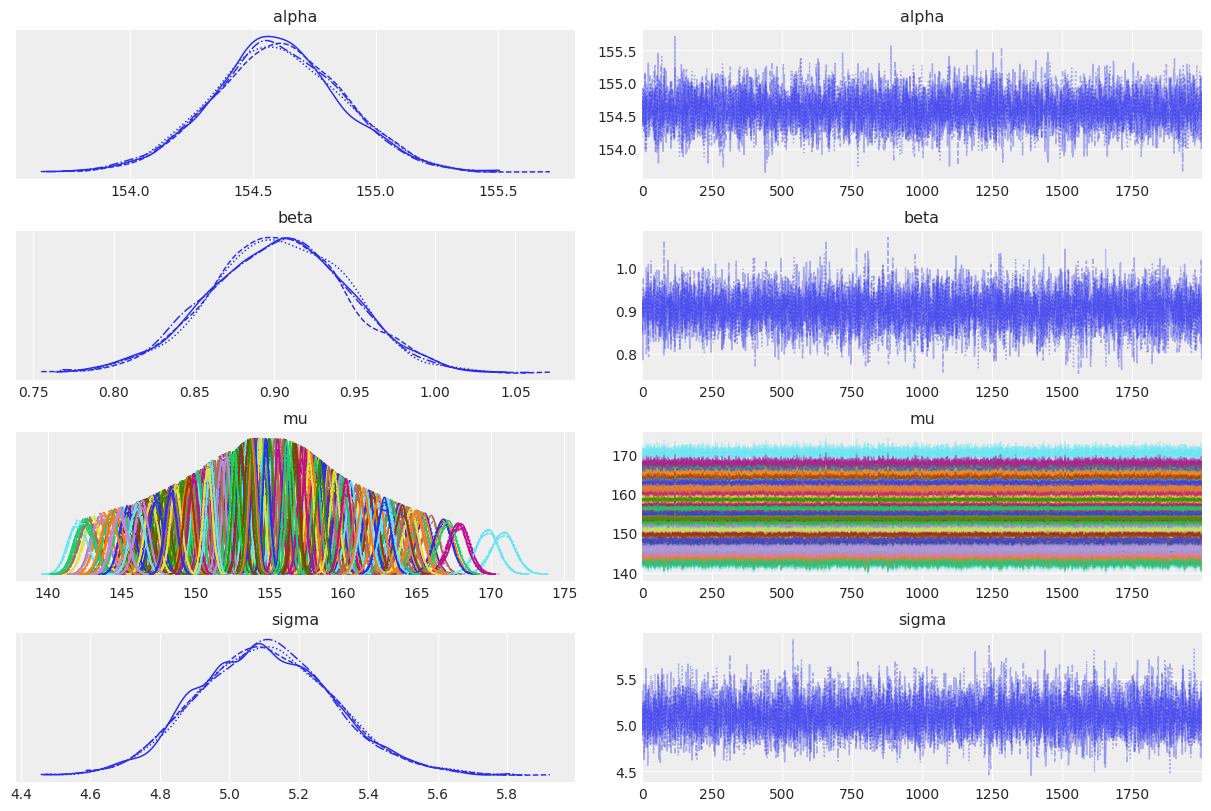

In [13]:
# This is quite slow...
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### Now we have the model fitted, we can do the posterior predictive check
### That is predict for each person in the dataset

In [14]:
predictive = numpyro.infer.Predictive(model, posterior_samples)
predictions = predictive(rng_key=random.PRNGKey(0), weight=df_adults.weight.values, height=None)
print('Shape of the predictions:\n', predictions['height'].shape, '\n')
print('First 5 predictions of height of the first 5 people:\n', predictions['height'][0:5,0:5], '\n')
print('Mean estimated height for the first 5 people:\n', predictions['height'][0:5,0:5].mean(axis=0), '\n')

Shape of the predictions:
 (8000, 352) 

First 5 predictions of height of the first 5 people:
 [[160.14926 153.50514 138.62791 154.66058 144.1501 ]
 [162.87085 143.83415 146.36581 166.01717 143.71242]
 [158.36925 152.9607  150.5305  160.87009 155.84375]
 [163.12291 136.51808 139.85733 149.23872 144.18317]
 [155.68466 141.9029  142.92447 167.11955 150.18057]] 

Mean estimated height for the first 5 people:
 [160.03938 145.74419 143.66121 159.58122 147.61398] 



In [15]:
# visualise the fits of the linear model to the data
height_CrI = jnp.percentile(predictions['height'], q=(5.5, 94.5), axis=0)
print(height_CrI[0:5, 0:5])

[[148.99464 138.73465 134.51363 153.92233 143.05286]
 [165.38715 155.20403 150.85461 169.78392 159.53372]]


In [16]:
height_CrI[0].shape

(352,)

In [17]:
df_adults.loc[:,'Predicted_mean'] = predictions['height'].mean(axis=0)
df_adults.loc[:,'Predicted_std'] = predictions['height'].std(axis=0)
df_adults.loc[:,'Predicted_P_5_5'] = height_CrI[0]
df_adults.loc[:,'Predicted_P_94_5'] = height_CrI[1]
df_adults.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,height,weight,age,male,Predicted_mean,Predicted_std,Predicted_P_5_5,Predicted_P_94_5
0,151.765,47.825606,63.0,1,157.194580,5.089615,148.994644,165.387146
1,139.700,36.485807,63.0,0,146.977020,5.169601,138.734650,155.204025
2,136.525,31.864838,65.0,0,142.702240,5.112236,134.513626,150.854614
3,156.845,53.041915,41.0,1,161.916122,5.021996,153.922333,169.783920
4,145.415,41.276872,51.0,0,151.205551,5.167632,143.052856,159.533722


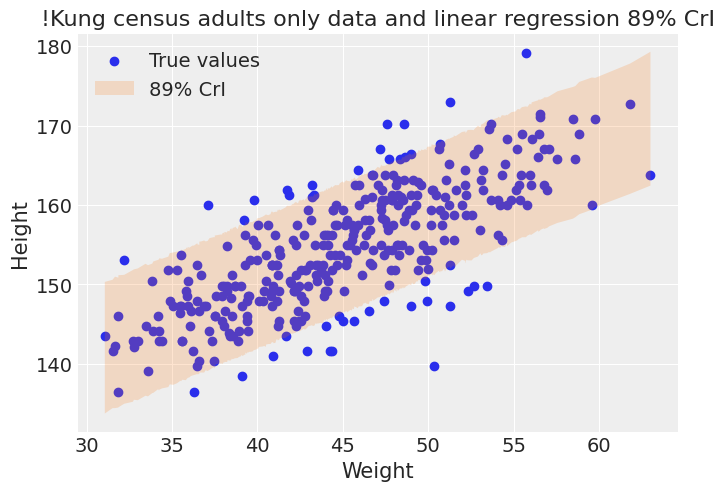

In [18]:
# finally plot!
df_adults_sorted = df_adults.sort_values('weight')  # needs to be sorted by weight just for plotting well with fill_between
plt.scatter(df_adults_sorted.weight.values, df_adults_sorted.height.values, label = 'True values')
plt.fill_between(df_adults_sorted.weight.values, y1=df_adults_sorted.Predicted_P_5_5.values, y2=df_adults_sorted.Predicted_P_94_5.values, alpha=0.2, label = '89% CrI')
plt.legend()
plt.ylabel('Height')
plt.xlabel('Weight')
plt.title('!Kung census adults only data and linear regression 89% CrI')
plt.show()

In [19]:
# Finally: make predictions for the 4 heights
weights_for_predictions = jnp.array([45, 40, 65, 31])
predictions_4 = predictive(rng_key=random.PRNGKey(0), weight=weights_for_predictions, height=None)
predictions_4_CrI = jnp.percentile(predictions_4['height'], q=(5.5, 94.5), axis=0)

predictions_4

{'height': DeviceArray([[154.3468 , 156.92505, 172.87492, 150.53682],
              [154.41747, 136.70374, 176.25111, 150.70062],
              [156.95139, 147.25662, 173.5512 , 155.17993],
              ...,
              [153.84746, 151.35707, 168.70567, 144.87985],
              [150.84929, 154.13759, 173.96976, 148.55887],
              [151.31667, 153.49835, 170.94435, 132.03392]], dtype=float32),
 'mu': DeviceArray([[154.76714, 150.1763 , 173.1305 , 141.9128 ],
              [154.82518, 150.7571 , 171.09753, 143.43454],
              [154.92314, 150.99188, 170.64818, 143.91562],
              ...,
              [155.10272, 150.90506, 171.89339, 143.34926],
              [154.3014 , 150.06046, 171.2652 , 142.42674],
              [154.55345, 150.19946, 171.96938, 142.3623 ]], dtype=float32)}

In [20]:
pred_4 = pd.DataFrame(columns=['Weight', 'Height_mean', 'Height_std', 'Height_P5_5', 'Height_P94_5'])
pred_4['Weight'] = weights_for_predictions
pred_4['Height_mean'] = predictions_4['height'].mean(axis=0)
pred_4['Height_std'] = predictions_4['height'].std(axis=0)
pred_4['Height_P5_5'] = predictions_4_CrI[0]
pred_4['Height_P94_5'] = predictions_4_CrI[1]
pred_4

,Weight,Height_mean,Height_std,Height_P5_5,Height_P94_5
0,45,154.581482,5.048803,146.553635,162.575043
1,40,150.066238,5.031558,142.068344,157.967209
2,65,172.754272,5.225966,164.523834,181.145935
3,31,141.903564,5.185728,133.584641,150.055481


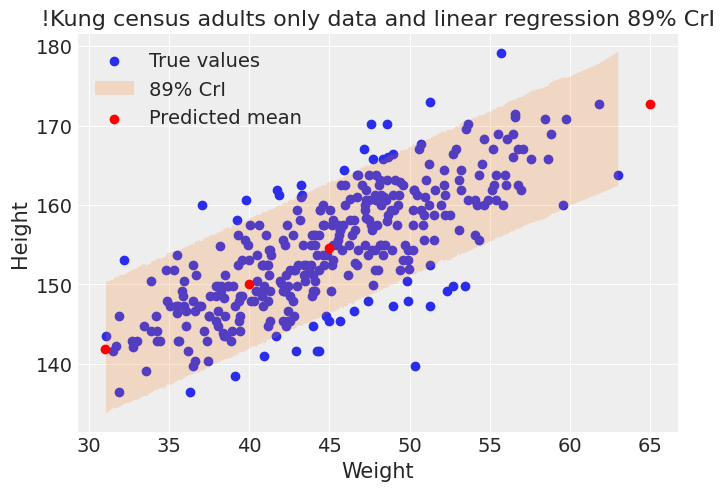

In [21]:
plt.scatter(df_adults_sorted.weight.values, df_adults_sorted.height.values, label = 'True values')
plt.fill_between(df_adults_sorted.weight.values, y1=df_adults_sorted.Predicted_P_5_5.values, y2=df_adults_sorted.Predicted_P_94_5.values, alpha=0.2, label = '89% CrI')
plt.scatter(pred_4.Weight.values, pred_4.Height_mean.values, color='red', label = 'Predicted mean')
plt.legend()
plt.ylabel('Height')
plt.xlabel('Weight')
plt.title('!Kung census adults only data and linear regression 89% CrI')
plt.show()

## Exercise 2

Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you think useful: an ordinary linear regression, a polynomial or a spline. I recommend a plain linear regression, though. Plot the posterior predictions against the raw data.

so basically the same as in exercise 1 but log(weight) instead of weight + use all population

All I've done is just adding the line transforming weight ot log(weight) in the model




In [46]:
def model(weight=None, height=None):
    # priors
    weight = jnp.log(weight)
    alpha = numpyro.sample("alpha", dist.Normal(165, 20))  # I just put my height in the prior
    beta = numpyro.sample("beta", dist.LogNormal(0, 1))  # same as in the book
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50)) # same as in the book

    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta * (weight - jnp.log(avg_weight)))
    # likelihood
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)   # not sure if i follow what this is doing

In [47]:
nuts_kernel = numpyro.infer.NUTS(model)

mcmc_ex2 = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000, chain_method='parallel')
rng_key = random.PRNGKey(0)
mcmc_ex2.run(rng_key, weight=df.weight.values, height=df.height.values)

posterior_samples_ex2 = mcmc_ex2.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 5788.58it/s, 1 steps of size 6.19e-01. acc. prob=0.93]


In [48]:
predictive = numpyro.infer.Predictive(model, posterior_samples_ex2)
predictions = predictive(rng_key=random.PRNGKey(0), weight=df.weight.values, height=None)
print('Shape of the predictions:\n', predictions['height'].shape, '\n')
print('First 5 predictions of height of the first 5 people:\n', predictions['height'][0:5,0:5], '\n')
print('Mean estimated height for the first 5 people:\n', predictions['height'][0:5,0:5].mean(axis=0), '\n')
height_CrI = jnp.percentile(predictions['height'], q=(5.5, 94.5), axis=0)
print(height_CrI[0:5, 0:5])

Shape of the predictions:
 (8000, 544) 

First 5 predictions of height of the first 5 people:
 [[159.8225  150.78207 141.08318 163.55981 150.8993 ]
 [157.46404 148.82391 141.08342 163.8632  154.17455]
 [160.62788 139.09656 145.97304 168.49263 145.69698]
 [150.1844  140.21451 140.36234 157.9036  149.36627]
 [159.60524 138.70673 136.35272 157.89156 151.18274]] 

Mean estimated height for the first 5 people:
 [157.5408  143.52475 140.97093 162.34215 150.26396] 

[[150.16393 137.2859  130.9794  155.15092 143.24158]
 [166.53204 153.8151  147.4817  171.21385 159.68672]]


In [49]:
df.loc[:,'Predicted_mean'] = predictions['height'].mean(axis=0)
df.loc[:,'Predicted_std'] = predictions['height'].std(axis=0)
df.loc[:,'Predicted_P_5_5'] = height_CrI[0]
df.loc[:,'Predicted_P_94_5'] = height_CrI[1]
df.head()

,height,weight,age,male,Predicted_mean,Predicted_std,Predicted_P_5_5,Predicted_P_94_5
0,151.765,47.825606,63.0,1,158.322998,5.182931,150.163925,166.532043
1,139.700,36.485807,63.0,0,145.520889,5.185438,137.285904,153.815094
2,136.525,31.864838,65.0,0,139.131119,5.204378,130.979401,147.481705
3,156.845,53.041915,41.0,1,163.172073,5.054302,155.150925,171.213852
4,145.415,41.276872,51.0,0,151.333969,5.128745,143.241577,159.686722


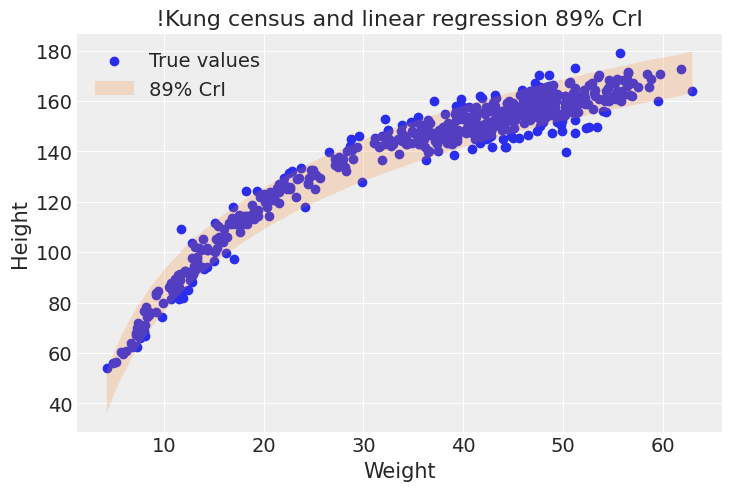

In [50]:
# finally plot!
df_sorted = df.sort_values('weight')  # needs to be sorted by weight just for plotting well with fill_between
plt.scatter(df_sorted.weight.values, df_sorted.height.values, label = 'True values')
plt.fill_between(df_sorted.weight.values, y1=df_sorted.Predicted_P_5_5.values, y2=df_sorted.Predicted_P_94_5.values, alpha=0.2, label = '89% CrI')
plt.legend()
plt.ylabel('Height')
plt.xlabel('Weight')
plt.title('!Kung census and linear regression 89% CrI')
plt.show()

## Exercise 3

Plot the prior predictive distribution for the polynomial regression model in Chapter 4. You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of alpha, beta_1, and beta_2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [90]:
weights_for_prior = jnp.linspace(0,70)

In [91]:
def model_poly(weight, height=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(165, 20))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1)) 
    beta2 = numpyro.sample("beta2", dist.Normal(0, 1))  
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50)) # same as in the book
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta1 * weight + beta2 * weight * weight)
    # likelihood
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)   # not sure if i follow what this is doing

In [92]:
prior_predictive = numpyro.infer.Predictive(model_poly, num_samples=30)
prior_predictions = prior_predictive(random.PRNGKey(0), weight=weights_for_prior, height=None)

In [93]:
prior_predictions.keys()

dict_keys(['alpha', 'beta1', 'beta2', 'height', 'mu', 'sigma'])

In [94]:
prior_predictions['mu'].shape

(30, 50)

In [103]:
mu = prior_predictions['mu']
mu

DeviceArray([[  159.34422,   161.12709,   160.8317 , ..., -2003.4512 ,
              -2099.346  , -2197.3193 ],
             [  171.15771,   173.87758,   179.12326, ...,  3029.3904 ,
               3150.8228 ,  3274.7817 ],
             [  188.20403,   188.856  ,   190.24968, ...,  1020.5986 ,
               1056.1091 ,  1092.3617 ],
             ...,
             [  139.05424,   140.20203,   142.06866, ...,   970.0896 ,
               1005.0238 ,  1040.677  ],
             [  164.9214 ,   165.79774,   167.20764, ...,   782.8456 ,
                808.7973 ,   835.28265],
             [  172.32608,   180.24832,   195.24937, ...,  8196.849  ,
               8537.473  ,  8885.178  ]], dtype=float32)

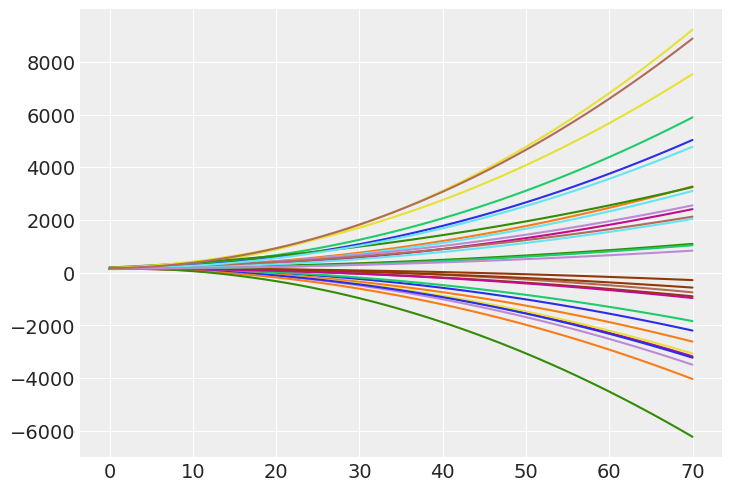

In [104]:
for i in range(len(mu)):
  plt.plot(weights_for_prior,mu[i,:])

## Clearly this does not seem right....

try to standardise the data?

In [105]:
weights_for_prior = jnp.linspace(0,70)
weights_for_prior_stand = (weights_for_prior - weights_for_prior.mean())/weights_for_prior.std()

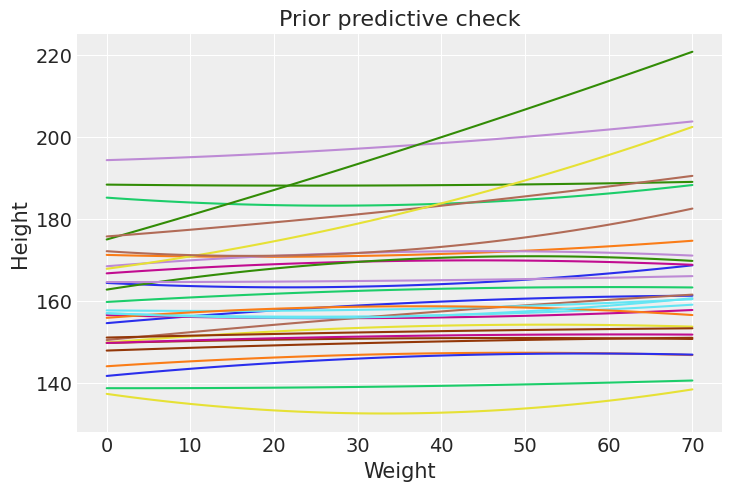

In [108]:
prior_predictive = numpyro.infer.Predictive(model_poly, num_samples=30)
prior_predictions = prior_predictive(random.PRNGKey(0), weight=weights_for_prior_stand, height=None)
mu = prior_predictions['mu']
for i in range(len(mu)):
  plt.plot(weights_for_prior,mu[i,:])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Prior predictive check')
plt.show()

## This looks more like what we wanted! But the prior does not seem good: a person of age -> 0 is around 140cm tall!!!!

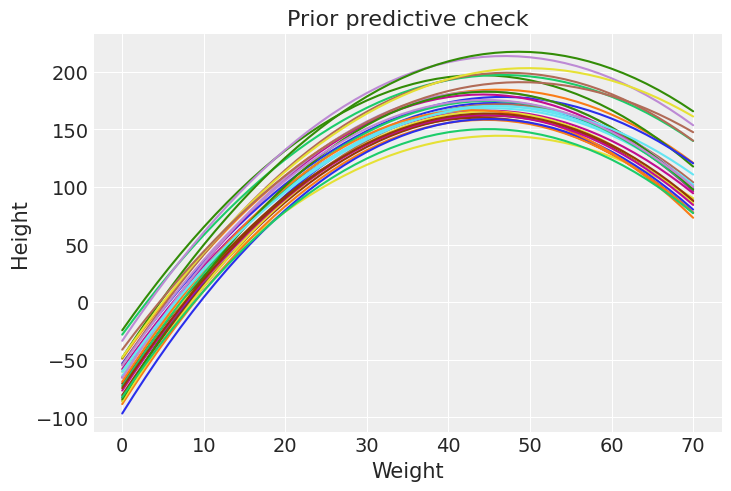

In [121]:
def model_poly(weight, height=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(165, 20))
    beta1 = numpyro.sample("beta1", dist.Normal(50, 5)) 
    beta2 = numpyro.sample("beta2", dist.Normal(-50, 5))  
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta1 * weight + beta2 * weight * weight)
    # likelihood
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

prior_predictive = numpyro.infer.Predictive(model_poly, num_samples=30)
prior_predictions = prior_predictive(random.PRNGKey(0), weight=weights_for_prior_stand, height=None)
mu = prior_predictions['mu']
for i in range(len(mu)):
  plt.plot(weights_for_prior,mu[i,:])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Prior predictive check')
plt.show()

## Still not great, weight below 0, height is decreasing at weight over 50....